In [17]:
from IPython.display import display
import os

# 上傳檔案（會跳出檔案選擇器）
from ipywidgets import FileUpload

upload = FileUpload()
display(upload)

FileUpload(value=(), description='Upload')

In [18]:
import os
from pathlib import Path

# 假設你只上傳了一個檔案
fileinfo = upload.value[0]  # 通常是一個 dict，含 'name' 和 'content'

# 顯示內容結構（除錯用）
print(fileinfo)

# 儲存 kaggle.json
filename = fileinfo['name']
content = fileinfo['content']

kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

kaggle_json_path = kaggle_dir / "kaggle.json"
with open(kaggle_json_path, "wb") as f:
    f.write(content)

# 設定權限（Linux/macOS 建議）
os.chmod(kaggle_json_path, 0o600)

print(f"{filename} 已成功儲存至 {kaggle_json_path}")

{'name': 'kaggle.json', 'type': 'application/json', 'size': 64, 'content': <memory at 0x762e4faa7640>, 'last_modified': datetime.datetime(2025, 4, 21, 6, 7, 11, 972000, tzinfo=datetime.timezone.utc)}
kaggle.json 已成功儲存至 /home/jovyan/.kaggle/kaggle.json


In [19]:
!kaggle datasets list -s cifar


ref                                                     title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------  ----------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
fedesoriano/cifar100                                    CIFAR-100 Python                                  168517809  2020-12-26 08:37:10.143000          12300        176  1.0              
pankrzysiu/cifar10-python                               CIFAR-10 Python                                   340613496  2018-01-27 13:42:40.967000          14829        252  0.75             
petitbonney/cifar10-image-recognition                   CIFAR-10                                         1007971063  2019-10-01 12:50:23.227000           2888         27  0.8235294        
valentynsichkar/cifar10-preprocessed                   

In [20]:
!pip install -U kaggle
!pip install --upgrade pandas
import os
import zipfile

# 建立 Kaggle 資料夾
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 下載 Dog Breed Identification 資料集
!kaggle competitions download -c dog-breed-identification --force
!unzip -oq dog-breed-identification.zip -d dog-breed-identification


import pandas as pd
import numpy as np

labels = pd.read_csv('dog-breed-identification/labels.csv')


cp: cannot stat 'kaggle.json': No such file or directory
100%|████████████████████████████████████████▊| 688M/691M [00:04<00:00, 155MB/s]
100%|█████████████████████████████████████████| 691M/691M [00:04<00:00, 158MB/s]
  error:  invalid compressed data to inflate dog-breed-identification/test/1f4561796f382f94df8c7779f3ebcb30.jpg
file #1320:  bad zipfile offset (lseek):  45498368
file #1321:  bad zipfile offset (lseek):  45531136
file #1322:  bad zipfile offset (lseek):  45563904
file #1323:  bad zipfile offset (lseek):  45580288
file #1324:  bad zipfile offset (lseek):  45621248
file #1325:  bad zipfile offset (lseek):  45637632
file #1326:  bad zipfile offset (lseek):  45654016
file #1327:  bad zipfile offset (lseek):  45678592
file #1328:  bad zipfile offset (lseek):  45703168
file #1329:  bad zipfile offset (lseek):  45752320
file #1330:  bad zipfile offset (lseek):  45809664
file #1331:  bad zipfile offset (lseek):  45834240
file #1332:  bad zipfile offset (lseek):  45858816
file #

In [21]:
import os
import shutil
import pandas as pd
from PIL import Image
from tqdm import tqdm
# 讀取標籤
labels = pd.read_csv('dog-breed-identification/labels.csv')
# 建立目標輸出資料夾
output_dir = "dog_images"
train_dir = os.path.join(output_dir, "train")
os.makedirs(train_dir, exist_ok=True)

# 根據標籤將圖片存入對應資料夾
def organize_train_images(labels): # Pass labels as an argument
    src_img_dir = "dog-breed-identification/train"
    for idx, row in tqdm(labels.iterrows(), total=len(labels)):
        img_id = row['id']
        breed = row['breed']
        src_path = os.path.join(src_img_dir, img_id + ".jpg")

        # 建立品種對應資料夾
        breed_dir = os.path.join(train_dir, breed)
        os.makedirs(breed_dir, exist_ok=True)

        dst_path = os.path.join(breed_dir, img_id + ".jpg")
        shutil.copyfile(src_path, dst_path)

# Load labels outside the function
labels = pd.read_csv('dog-breed-identification/labels.csv')
organize_train_images(labels) # Call the function with labels argument

100%|██████████| 10222/10222 [00:52<00:00, 194.50it/s]


In [22]:
 #自定義 Dataset 類別
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

from PIL import UnidentifiedImageError
class DogBreedImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # 建立類別對應表：品種 → 數值 label
        class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name in class_names:
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_folder):
                continue
            for filename in os.listdir(class_folder):
                if filename.endswith(('.jpg', '.png')):
                    self.image_paths.append(os.path.join(class_folder, filename))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [23]:
# 定義 Transform
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomRotation, ToTensor, Normalize

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225)),
])



test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3),
])

In [24]:
# 建立 Dataset 與切分
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler
import collections
from collections import Counter

# 讀取分類後資料
dataset = DogBreedImageFolder("dog_images/train", transform=train_transform)

# 計算資料數量與切分比例
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 取得 training set 的原始 indices
train_indices = train_dataset.indices  # 是 dataset 中對應的索引
train_labels = [dataset.labels[i] for i in train_indices]

# 計算類別樣本數與每個 sample 權重
label_counts = Counter(train_labels)
class_sample_counts = [label_counts[i] for i in range(len(label_counts))]
sample_weights = [1.0 / class_sample_counts[label] for label in train_labels]

# 建立 WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# 顯示類別分布（驗證分布仍可看是否合理）
val_labels = [dataset.labels[i] for i in val_dataset.indices]
print("Train label distribution:", Counter(train_labels))
print("Val label distribution:", Counter(val_labels))


Train label distribution: Counter({11: 100, 97: 98, 100: 94, 1: 94, 52: 91, 7: 90, 61: 88, 94: 88, 73: 88, 9: 86, 69: 85, 109: 84, 59: 84, 75: 83, 13: 83, 42: 83, 93: 83, 68: 82, 3: 81, 26: 80, 86: 79, 87: 78, 117: 77, 84: 77, 30: 77, 55: 76, 39: 76, 80: 76, 116: 75, 98: 75, 63: 74, 6: 74, 64: 74, 8: 73, 33: 73, 17: 73, 2: 72, 35: 72, 79: 72, 10: 72, 19: 71, 88: 71, 105: 71, 101: 71, 95: 70, 78: 70, 102: 70, 70: 70, 28: 70, 90: 69, 82: 69, 56: 69, 60: 68, 14: 68, 15: 68, 114: 68, 41: 67, 118: 67, 53: 67, 31: 66, 58: 66, 40: 65, 119: 65, 76: 65, 47: 65, 20: 65, 50: 65, 62: 65, 54: 65, 96: 64, 67: 64, 37: 64, 115: 64, 25: 63, 74: 62, 57: 62, 92: 62, 71: 62, 36: 62, 34: 62, 110: 61, 111: 61, 107: 61, 104: 61, 0: 60, 44: 60, 45: 60, 85: 60, 89: 60, 99: 59, 5: 59, 12: 59, 21: 59, 103: 59, 24: 58, 81: 58, 29: 58, 91: 57, 16: 57, 77: 57, 32: 57, 38: 57, 72: 56, 51: 56, 108: 56, 4: 56, 46: 56, 18: 55, 22: 55, 83: 55, 113: 55, 49: 55, 27: 54, 106: 54, 48: 54, 66: 54, 65: 54, 23: 54, 43: 52, 112

In [25]:
#驗證資料載入
# 驗證一個 batch
for images, labels in train_loader:
    print("Images shape:", images.shape)  # [B, 3, 224, 224]
    print("Labels shape:", labels.shape)  # [B]
    break

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


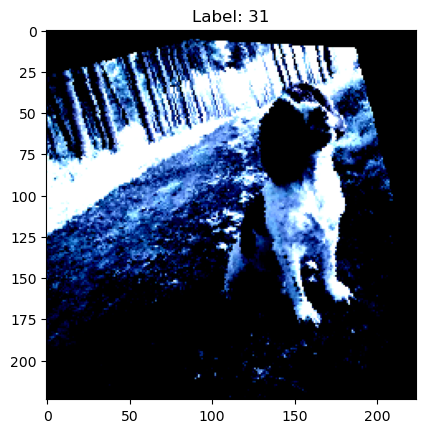

In [26]:
# 如果需要視覺化一個 batch
import matplotlib.pyplot as plt
def show_batch(loader):
    images, labels = next(iter(loader))
    img = images[0].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"Label: {labels[0]}")
    plt.show()

show_batch(train_loader)

In [32]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()


In [33]:
!pip install timm


In [34]:
import torch
import torch.nn as nn
import torchvision.models as models

num_classes = 120  # Dog Breed Identification 有 120 類別
import torch
import torch.nn as nn
import timm

class TwoModelFusion(nn.Module):
    def __init__(self, num_classes=120, pretrained=True):
        super().__init__()
        # 模型1：Xception
        self.model1 = timm.create_model('xception', pretrained=pretrained, num_classes=0)  # num_classes=0 表示去除最後分類層，只輸出特徵
        self.feature_dim1 = self.model1.num_features  # xception 輸出特徵維度
        
        # 模型2：ResNet50
        self.model2 = timm.create_model('resnet50', pretrained=pretrained, num_classes=0)
        self.feature_dim2 = self.model2.num_features
        
        # 融合後的 FC 層
        fused_dim = self.feature_dim1 + self.feature_dim2
        self.classifier = nn.Sequential(
            nn.Linear(fused_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        feat1 = self.model1(x)
        feat2 = self.model2(x)

        # 如果 feat1, feat2 是4維（batch, C, H, W）
        if len(feat1.shape) > 2:
            feat1 = torch.flatten(feat1, start_dim=1)
        if len(feat2.shape) > 2:
            feat2 = torch.flatten(feat2, start_dim=1)

        fused = torch.cat([feat1, feat2], dim=1)
       
        out = self.classifier(fused)
        return out

# 使用範例
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TwoModelFusion(num_classes=120).to(device)

# 假設已有 train_loader, val_loader, criterion, optimizer ...


In [35]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
num_epochs = 50
# 1. 計算 class weights（根據整體 dataset 分布）
from collections import Counter

label_counts = Counter(dataset.labels)
num_classes = 120
class_counts = [label_counts[i] for i in range(num_classes)]

# 權重：類別樣本越少，損失權重越高
weights = [1.0 / c for c in class_counts]
weights = torch.tensor(weights, dtype=torch.float).to(device)
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# 定義損失函數與優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)


In [36]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    torch.cuda.empty_cache()  # ⚠️ 清除不必要的 CUDA 記憶體

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():  # ✅ 自動混合精度
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step(epoch)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # 驗證
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    torch.cuda.empty_cache()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch 1/50, Loss: 3.2630, Accuracy: 31.29%
Validation Loss: 1.2540, Validation Accuracy: 66.39%
Epoch 2/50, Loss: 1.1297, Accuracy: 67.11%
Validation Loss: 0.8611, Validation Accuracy: 74.41%
Epoch 3/50, Loss: 0.8276, Accuracy: 75.06%
Validation Loss: 0.9309, Validation Accuracy: 72.80%
Epoch 4/50, Loss: 0.6778, Accuracy: 79.79%
Validation Loss: 0.8469, Validation Accuracy: 74.71%
Epoch 5/50, Loss: 0.4412, Accuracy: 86.55%
Validation Loss: 0.7229, Validation Accuracy: 79.21%
Epoch 6/50, Loss: 0.3620, Accuracy: 88.93%
Validation Loss: 0.6876, Validation Accuracy: 78.62%
Epoch 7/50, Loss: 0.3060, Accuracy: 90.84%
Validation Loss: 0.7439, Validation Accuracy: 79.50%
Epoch 8/50, Loss: 0.2382, Accuracy: 92.82%
Validation Loss: 0.6603, Validation Accuracy: 80.97%
Epoch 9/50, Loss: 0.1953, Accuracy: 94.34%
Validation Loss: 0.6649, Validation Accuracy: 82.00%
Epoch 10/50, Loss: 0.1911, Accuracy: 94.33%
Validation Loss: 0.6708, Validation Accuracy: 80.48%
Epoch 11/50, Loss: 0.1646, Accuracy: 94

In [37]:
# 保存訓練後的模型
torch.save(model.state_dict(), "dog_breed_model.pth")


In [38]:
# 測試集的評估
test_accuracy = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        test_accuracy += (predicted == labels).sum().item()

test_accuracy = 100 * test_accuracy / len(val_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}%")

import os

Test Accuracy: 82.53%


In [39]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TestImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_filenames = sorted(os.listdir(image_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name.split('.')[0]  # 傳回 image tensor 和 id（

In [40]:
# 取得所有類別名稱，需排序以符合 submission 格式
all_breeds = sorted(dataset.class_to_idx.keys())

# 建立 mapping
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
# 修正 Test transform 使用與訓練相同的 ImageNet 格式
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  # 與訓練相同
                         (0.229, 0.224, 0.225))
])


# 設定測試資料夾路徑
test_folder = 'dog-breed-identification/test'  # 請確認實際位置

# 建立 DataLoader
test_dataset = TestImageDataset(test_folder, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 建立 DataFrame 儲存預測結果
results = []

In [41]:
# 使用 softmax 輸出機率
results = []

with torch.no_grad():
    for inputs, image_ids in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()  # shape: (batch_size, 120)

        for img_id, prob_vector in zip(image_ids, probs):
            row = {"id": img_id}
            for breed, prob in zip(all_breeds, prob_vector):
                row[breed] = prob
            results.append(row)

# 轉成 DataFrame 並輸出
df = pd.DataFrame(results)
df = df[["id"] + all_breeds]  # 確保順序符合要求
df.to_csv("submission_mix111111.csv", index=False)
print("✅ submission4.csv 已成功輸出，格式符合 Kaggle 要求！")


✅ submission4.csv 已成功輸出，格式符合 Kaggle 要求！
